<a href="https://colab.research.google.com/github/HuynhThanhQuan/thyroid-nodule-detector/blob/main/test_fold1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


# Down load the data and pretrained weight of DDTI

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1wwlsEhwfSyvQsJBRjeDLhUjqZh8eaH2R'
output = r'/content/sample_data/DDTI.zip'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=16CldjuNztEZp2E3SJzXTHp--JggiNCMX'
output = r'/content/sample_data/DDTI_weight.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1wwlsEhwfSyvQsJBRjeDLhUjqZh8eaH2R
To: /content/sample_data/DDTI.zip
100%|██████████| 137M/137M [00:02<00:00, 46.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=16CldjuNztEZp2E3SJzXTHp--JggiNCMX
To: /content/sample_data/DDTI_weight.zip
100%|██████████| 628M/628M [00:07<00:00, 81.3MB/s]


'/content/sample_data/DDTI_weight.zip'

# Unzip the data to the appropriate folder

In [ ]:
!unzip -q /content/sample_data/DDTI.zip # uzip with Quiet mode
!unzip -q /content/sample_data/DDTI_weight.zip # uzip with Quiet mode

# Clone the TNSCUI 1st repo and uzip

In [ ]:
!git clone https://github.com/WAMAWAMA/TNSCUI2020-Seg-Rank1st
!cp -r /content/TNSCUI2020-Seg-Rank1st/step2to4_train_validate_inference/. /content


Cloning into 'TNSCUI2020-Seg-Rank1st'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 283 (delta 42), reused 78 (delta 26), pack-reused 182
Receiving objects: 100% (283/283), 1.49 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (64/64), done.


# Requirement

In [ ]:
!pip install segmentation-models-pytorch
!pip install ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 6.6 MB/s 
     |████████████████████████████████| 376 kB 40.1 MB/s 
     |████████████████████████████████| 58 kB 685 kB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=bc9137d0e262348222b51dfaa997ad679c8cf8b0f38171ba46c3c2276e6bcd82
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=dc4919ae9bc9971cb0c53b7edae0b449936c3254baeca6c0d2e680660366199d
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Test

In [ ]:
#@title
import torch
import ttach as tta
from PIL import Image
from skimage.measure import label as sklabel
from skimage.measure import regionprops
from skimage.transform import resize
from torchvision import transforms as T
import xlrd
import segmentation_models_pytorch_4TorchLessThan120 as smp
from tnscui_utils.TNSCUI_preprocess import TNSCUI_preprocess
from tnscui_utils.TNSUCI_util import *


def getIOU(SR,GT):
    """
    都是二值图
    :param SR: binary image
    :param GT: binary image
    :return:
    """
    TP = (SR+GT==2).astype(np.float32)
    FP = (SR+(1-GT)==2).astype(np.float32)
    FN = ((1-SR)+GT==2).astype(np.float32)

    IOU = float(np.sum(TP))/(float(np.sum(TP+FP+FN)) + 1e-6)

    return IOU

def getDSC(SR,GT):
    """
    都是二值图
    :param SR: binary image
    :param GT: binary image
    :return:
    """


    Inter = np.sum(((SR+GT)==2).astype(np.float32))
    DC = float(2*Inter)/(float(np.sum(SR)+np.sum(GT)) + 1e-6)

    return DC

def largestConnectComponent(bw_img):
    if np.sum(bw_img)==0:
        return bw_img
    labeled_img, num = sklabel(bw_img, background=0, return_num=True)
    if num == 1:
        return bw_img


    max_label = 0
    max_num = 0
    for i in range(0,num):
        print(i)
        if np.sum(labeled_img == (i+1)) > max_num:
            max_num = np.sum(labeled_img == (i+1))
            max_label = i+1
    mcr = (labeled_img == max_label)
    return mcr.astype(np.int)


def preprocess(mask_c1_array_biggest, c1_size=256):
    if np.sum(mask_c1_array_biggest) == 0:
            minr, minc, maxr, maxc = [0, 0, c1_size, c1_size]
    else:
        region = regionprops(mask_c1_array_biggest)[0]
        minr, minc, maxr, maxc = region.bbox

    dim1_center, dim2_center = [(maxr + minr) // 2, (maxc + minc) // 2]
    max_length = max(maxr - minr, maxc - minc)

    max_lengthl = int((c1_size/256)*80)
    preprocess1 = int((c1_size/256)*19)
    pp22 = int((c1_size/256)*31)


    if max_length > max_lengthl:
        ex_pixel = preprocess1 + max_length // 2
    else:
        ex_pixel = pp22 + max_length // 2

    dim1_cut_min = dim1_center - ex_pixel
    dim1_cut_max = dim1_center + ex_pixel
    dim2_cut_min = dim2_center - ex_pixel
    dim2_cut_max = dim2_center + ex_pixel

    if dim1_cut_min < 0:
        dim1_cut_min = 0
    if dim2_cut_min < 0:
        dim2_cut_min = 0
    if dim1_cut_max > c1_size:
        dim1_cut_max = c1_size
    if dim2_cut_max > c1_size:
        dim2_cut_max = c1_size
    return [dim1_cut_min,dim1_cut_max,dim2_cut_min,dim2_cut_max]


if __name__ == '__main__':
    """处理的逻辑:
    1)读取图片,有mask则读取mask
    2)图片预处理,比如去黑边的操作,保留去黑边的坐标index1
    3)cascade1,使用TTA,预测mask(后续可以加后处理,如cascadePSP)
    4)预测mask的roi,上下左右随机外扩不同像素,相当于一种tta,然后储存tta外扩像素细节到一个list,为index2
    5)cascade2,使用TTA,在抠出图基础上(resize到256)进行预测,之后还原大小,(后续可以加后处理,如cascadePSP)
    6)根据index2,还原分割结果到原位置,再根据index1,还原到最初位置
    7)和mask计算指标
    """
    """
    logic of this code:
    1) Read the picture and read the mask if you have one
    2) Image preprocessing, such as the operation of de-blackened edge, and the coordinate index1 of de-blackened edge shall be retained
    3) Cascade1, Using TTA, Predictive Mask (which can be added later, such as cascadePSP)
    4) Mask ROI is predicted. Different pixels are randomly expanded up, down, left and right, which is equivalent to a tta. Then details of TTA's expanded pixels are stored in a list, which is index2
    5) Cascade2, Using TTA, predicting on the basis of the carded figure (resize to 256), and then recovering the size,(subsequent processing can be added, such as cascadePSP)
    6) Restore the segmentation results to the original location according to Index2, and then restore to the original location according to Index1
    7) and mask calculate indicators

    """
    saveas = 'mask' # mask二值图形式保存
    # 路径设置
    img_path = r'/content/1_or_data/image'
    mask_path = r'/content/1_or_data/mask'
    fold_id = r'/content/DDTI/fold1_id.xlsx'

    # task_name
    task_name = r' '

    # cascade参数
    weight_c1=r'/content/DDTI/fold1_stage1_trained_on_size_256.pkl'
    weight_c2=r'/content/DDTI/fold1_stage2_trained_on_size_512.pkl'

    c1_size = 256
    c1_tta = True
    orimg=False

    use_c2_flag = True
    c2_tta = True
    c2_size = 512
    c2_resize_order = 0
    # GPU
    cuda_idx = 0


# ===============================================================================================

    # 设置GPU相关
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_idx)


    # ===============
    device = torch.device('cuda')
    # 读取测试集
    data_xlsx = xlrd.open_workbook(fold_id)
    table = data_xlsx.sheet_by_name('valid')
    fold_id_all = [int(table.cell_value(i,0)) for i in range(1,table.nrows)]
    test_img_list = get_filelist_frompath(img_path,'PNG',sample_id=fold_id_all)
    test_mask_list = [mask_path + sep + i.split(sep)[-1] for i in test_img_list]


    # 构建两个模型
    with torch.no_grad():
        # tta设置
        tta_trans = tta.Compose([
            tta.VerticalFlip(),
            tta.HorizontalFlip(),
            tta.Rotate90(angles=[0,180]),
        ])
        # 构建模型
        # cascade1
        model_cascade1 = smp.DeepLabV3Plus(encoder_name="efficientnet-b6", encoder_weights=None, in_channels=1, classes=1)
        model_cascade1.to(device)
        model_cascade1.load_state_dict(torch.load(weight_c1),strict=True)
        # model_cascade1 = torch.load(weight_c1)
        if c1_tta:
            model_cascade1 = tta.SegmentationTTAWrapper(model_cascade1, tta_trans,merge_mode='mean')
        model_cascade1.eval()
        # cascade2
        model_cascade2 = smp.DeepLabV3Plus(encoder_name="efficientnet-b6", encoder_weights=None, in_channels=1, classes=1)
        # model_cascade2 = smp.Unet(encoder_name="efficientnet-b6", encoder_weights=None, in_channels=1, classes=1, encoder_depth=5, decoder_attention_type='scse')
        # model_cascade2 = smp.PAN(encoder_name="efficientnet-b6",encoder_weights='imagenet',	in_channels=1, classes=1)
        model_cascade2.to(device)
        model_cascade2.load_state_dict(torch.load(weight_c2),strict=True)
        if c2_tta:
            model_cascade2 = tta.SegmentationTTAWrapper(model_cascade2, tta_trans,merge_mode='mean')
        model_cascade2.eval()


        # 指标
        IOU_list = []
        DSC_list = []
        ioumin3 = 0

        #
        for index, img_file in enumerate(test_img_list):
            print(task_name,'\n',img_file,index+1,'/',len(test_img_list),' c1:',c1_size,' c2: ', c2_size)
            with torch.no_grad():

                # 读取GT数据
                if mask_path is not None:
                    mask_file = test_mask_list[index]
                    GT = Image.open(mask_file)
                    Transform_GT = T.Compose([T.ToTensor()])
                    GT = Transform_GT(GT)
                    GT_array = (torch.squeeze(GT)).data.cpu().numpy()



                # 处理原图
                img, cut_image_orshape, or_shape, location = TNSCUI_preprocess(img_file,outputsize=c1_size,orimg=orimg)
                img = torch.unsqueeze(img, 0)
                img = torch.unsqueeze(img, 0)
                img = img.to(device)
                img_array = (torch.squeeze(img)).data.cpu().numpy()

                """过一遍cascade1"""
                # 获取cascade1输出
                with torch.no_grad():
                    mask_c1 = model_cascade1(img)
                    mask_c1 = torch.sigmoid(mask_c1)
                    mask_c1_array = (torch.squeeze(mask_c1)).data.cpu().numpy()
                    mask_c1_array = (mask_c1_array>0.5)
                    mask_c1_array = mask_c1_array.astype(np.float32)
                    # 获取最大联通域
                    mask_c1_array_biggest = largestConnectComponent(mask_c1_array.astype(np.int))
                    print("c1 outputsize:",mask_c1_array_biggest.shape)



                """过一遍cascade2"""
                with torch.no_grad():
                    if use_c2_flag:
                        # 获取roi的bounding box坐标
                        dim1_cut_min, dim1_cut_max, dim2_cut_min, dim2_cut_max = preprocess(mask_c1_array_biggest,c1_size)
                        # 根据roi的bounding box坐标，获取img区域
                        img_array_roi = img_array[dim1_cut_min:dim1_cut_max,dim2_cut_min:dim2_cut_max]
                        img_array_roi_shape = img_array_roi.shape
                        img_array_roi = resize(img_array_roi, (c2_size, c2_size), order=3)
                        img_array_roi_tensor = torch.tensor(data = img_array_roi,dtype=img.dtype)
                        img_array_roi_tensor = torch.unsqueeze(img_array_roi_tensor,0)
                        img_array_roi_tensor = torch.unsqueeze(img_array_roi_tensor,0).to(device)
                        # 获取cascade2输出,并还原大小
                        print('use cascade2')
                        mask_c2 = model_cascade2(img_array_roi_tensor)
                        mask_c2 = torch.sigmoid(mask_c2)
                        mask_c2_array = (torch.squeeze(mask_c2)).data.cpu().numpy()
                        if saveas == 'mask':
                            cascade2_t = 0.5
                            mask_c2_array = (mask_c2_array>cascade2_t)
                            # print(cascade2_t)
                        mask_c2_array = mask_c2_array.astype(np.float32)
                        mask_c2_array = resize(mask_c2_array, img_array_roi_shape, order=c2_resize_order)
                        # 放回cascade1输出的mask
                        mask_c1_array_biggest = mask_c1_array_biggest.astype(np.float32)  # new
                        mask_c1_array_biggest[dim1_cut_min:dim1_cut_max, dim2_cut_min:dim2_cut_max] = mask_c2_array
                        mask_c1_array_biggest = mask_c1_array_biggest.astype(np.float32)
                        # print(np.unique(mask_c1_array_biggest))
                        # print(np.sum(mask_c1_array_biggest))


                # 根据预处理信息，首先还原到原始size，之后放回原图位置
                mask_c1_array_biggest = mask_c1_array_biggest.astype(np.float32)
                final_mask = np.zeros(shape=or_shape, dtype=mask_c1_array_biggest.dtype)
                mask_c1_array_biggest = resize(mask_c1_array_biggest, cut_image_orshape, order=1)
                final_mask[location[0]:location[1],location[2]:location[3]]=mask_c1_array_biggest

                #
                final_img = np.zeros(shape=or_shape, dtype=mask_c1_array_biggest.dtype)
                img_array_biggest = resize(img_array, cut_image_orshape, order=1)
                final_img[location[0]:location[1],location[2]:location[3]]=img_array_biggest

                # 变成二值图
                if saveas == 'mask':
                    final_mask = (final_mask > 0.5)
                    # final_mask = (final_mask > 0.05)
                final_mask = final_mask.astype(np.float32)
                # print(np.unique(final_mask))
                # print(np.sum(final_mask))

                print(np.unique(GT_array))
                # 如果有GT的话，计算指标
                if mask_path is not None:
                    GT_array = (GT_array > 0.5)
                    GT_array = GT_array.astype(np.float32)
                    if getIOU(final_mask, GT_array)<0.3:
                        ioumin3 = ioumin3+1
                    IOU_list.append(getIOU(final_mask, GT_array))
                    print('IOU:',getIOU(final_mask, GT_array))
                    IOU_final = np.mean(IOU_list)
                    print('IOU_final',IOU_final)

                    DSC_list.append(getDSC(final_mask, GT_array))
                    print('DSC:',getDSC(final_mask, GT_array))
                    DSC_final = np.mean(DSC_list)
                    print('DSC_final',DSC_final)

                if mask_file.split(sep)[-1]=='qwe.PNG':
                  break

            # plt.subplot(1, 2, 1)
            # plt.imshow(mask_c1_array_biggest,cmap=plt.cm.gray)
            # # plt.imshow(final_mask,cmap=plt.cm.gray)
            # plt.subplot(1, 2, 2)
            # plt.imshow(img_array,cmap=plt.cm.gray)
            # plt.show()


    print((ioumin3))

/content/segmentation_models_pytorch_4TorchLessThan120/__init__.py:14: UserWarning: segmentation_models_pytorch_4TorchLessThan120 does not suppose timm_efficientnet_encoders
  warnings.warn('segmentation_models_pytorch_4TorchLessThan120 does not suppose timm_efficientnet_encoders')


  
 /content/1_or_data/image/10048.PNG 1 / 129  c1: 256  c2:  512
c1 outputsize: (256, 256)
use cascade2
[0. 1.]
IOU: 0.8833003672854874
IOU_final 0.8833003672854874
DSC: 0.9380345085990087
DSC_final 0.9380345085990087
  
 /content/1_or_data/image/316.PNG 2 / 129  c1: 256  c2:  512
c1 outputsize: (256, 256)
use cascade2
[0. 1.]
IOU: 0.8401290024372116
IOU_final 0.8617146848613495
DSC: 0.9131196794621231
DSC_final 0.9255770940305659
  
 /content/1_or_data/image/10139.PNG 3 / 129  c1: 256  c2:  512
c1 outputsize: (256, 256)
use cascade2
[0. 1.]
IOU: 0.856022808064618
IOU_final 0.8598173925957724
DSC: 0.9224270352121828
DSC_final 0.9245270744244382
  
 /content/1_or_data/image/20088.PNG 4 / 129  c1: 256  c2:  512
c1 outputsize: (256, 256)
use cascade2
[0. 1.]
IOU: 0.8089333520066319
IOU_final 0.8470963824484873
DSC: 0.8943760709694363
DSC_final 0.9169893235606877
  
 /content/1_or_data/image/53.PNG 5 / 129  c1: 256  c2:  512
c1 outputsize: (256, 256)
use cascade2
[0. 1.]
IOU: 0.9195544553

In [ ]:
print('IOU_final',IOU_final)
print('DSC_final',DSC_final)

IOU_final 0.763563378739906
DSC_final 0.8482545029623303


show result

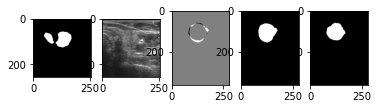

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1, 5, 1)
plt.imshow(mask_c1_array,cmap=plt.cm.gray)
plt.subplot(1, 5, 2)
plt.imshow(img_array,cmap=plt.cm.gray)
# plt.imshow(final_mask,cmap=plt.cm.gray)
plt.subplot(1, 5, 3)
plt.imshow(final_mask-GT_array,cmap=plt.cm.gray)
plt.subplot(1, 5, 4)
plt.imshow(final_mask,cmap=plt.cm.gray)
plt.subplot(1, 5, 5)
plt.imshow(GT_array,cmap=plt.cm.gray)
GT_array = (GT_array > 0.5)
GT_array = GT_array.astype(np.float32)
plt.show()
